In [2]:
%reload_ext autoreload
%autoreload 1
from ray import tune, train
import shap
import matplotlib.pyplot as plt
import polars as pl
import sys
import numpy as np
from sklearn.model_selection import train_test_split
import functions.transformers as tr
import functions.data_manipulation_functions as dmf
import functions.plot_functions as pf
import functions.tuning as tunes
import seaborn as sns
from sklearn.compose import ColumnTransformer
from sklearn.pipeline import Pipeline
from sklearn.metrics import classification_report
from sklearn.preprocessing import LabelEncoder
from sklearn.preprocessing import OneHotEncoder
import lightgbm as lgb
%aimport functions.tuning
%aimport functions.transformers
%aimport functions.data_manipulation_functions
%aimport functions.plot_functions

In [3]:
BASE_FIG_SIZE=(8.5,4.5)
sns.set()

In [4]:
data_sample=pl.read_parquet('data/data_sample.parquet')

In [5]:
data_sample=dmf.title_text_features(data_sample)

In [6]:
X_mini_train, X_mini_val, y_mini_train, y_mini_val = train_test_split(
    data_sample.drop(columns="Policy Code"),
    data_sample["Policy Code"],
    test_size=0.3,
    stratify=data_sample["Policy Code"],
)

# stop here

In [7]:
title_cat_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)
zip_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
state_imputer=tr.NotInImputerPolars(cat_no=10,fill_value=None)
emp_length_imputer=tr.NotInImputerPolars(cat_no=12,fill_value=None)

imputer = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(title_cat_imputer, "title"),
        tr.PolarsColumnTransformer.Step(zip_imputer, "Zip Code"),
        tr.PolarsColumnTransformer.Step(state_imputer, "State"),
        tr.PolarsColumnTransformer.Step(emp_length_imputer, "Employment Length"),
    ]
)

In [8]:
numeric_columns = X_mini_train.select(pl.selectors.by_dtype(pl.NUMERIC_DTYPES)).columns
categorical_columns = [col for col in X_mini_train.columns if col not in numeric_columns]
numeric_columns_idx=[X_mini_train.columns.index(val) for val in numeric_columns]
categorical_column_idx=[X_mini_train.columns.index(val) for val in categorical_columns]

In [9]:
state_encoder = tr.PolarsOneHotEncoder()
zip_encoder = tr.PolarsOneHotEncoder()
title_encoder = tr.PolarsOneHotEncoder()
length_order = [
    None,
    "< 1 year",
    "1 year",
    "2 years",
    "3 years",
    "4 years",
    "5 years",
    "6 years",
    "7 years",
    "8 years",
    "9 years",
    "10+ years",
]

employment_encoder=tr.PolarsOrdinalEncoder(order=length_order)
encoder = tr.PolarsColumnTransformer(
    [
        tr.PolarsColumnTransformer.Step(state_encoder, "State"),
        tr.PolarsColumnTransformer.Step(zip_encoder, "Zip Code"),
        tr.PolarsColumnTransformer.Step(title_encoder, "title"),
        tr.PolarsColumnTransformer.Step(employment_encoder, "Employment Length"),
    ]
)

In [10]:
loan_classifier = lgb.LGBMClassifier(
    class_weight="balanced", force_col_wise=True, verbose=-1, num_threads=1,random_state=1
)

full_pipeline = Pipeline(
    [
        ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder)])),
        ("model", loan_classifier),
    ]
)

In [13]:
search_space_lgbm = {
    "model__num_leaves": tune.randint(10, 200),
    "model__n_estimators": tune.randint(10, 250),
    "model__learning_rate": tune.loguniform(0.001, 0.1),
    "model__colsample_bytree": tune.uniform(0.5, 1.0),
    "model__subsample": tune.uniform(0.5, 1.0),
    "model__reg_alpha": tune.loguniform(0.001, 1.0),
    "model__reg_lambda": tune.loguniform(0.001, 1.0),
    "model__boosting_type": tune.choice(["gbdt", "dart", "rf"]),
}

models=tunes.Models()
models.add_model('lgbm_yn',full_pipeline,search_space_lgbm)


models.tune_all(X_mini_train,y_mini_train,X_mini_val,y_mini_val,n=20)

(Trainable pid=20541) {'model__num_leaves': 80, 'model__n_estimators': 79, 'model__learning_rate': 0.01948252501738008, 'model__colsample_bytree': 0.9723605760950115, 'model__subsample': 0.7289888384637044, 'model__reg_alpha': 0.18395496863959396, 'model__reg_lambda': 0.013707042468039507, 'model__boosting_type': 'dart'}
(Trainable pid=20541) Step 0 F-1 Score: 0.6187270501835985
(Trainable pid=20541) {'model__num_leaves': 80, 'model__n_estimators': 79, 'model__learning_rate': 0.01948252501738008, 'model__colsample_bytree': 0.9723605760950115, 'model__subsample': 0.7289888384637044, 'model__reg_alpha': 0.18395496863959396, 'model__reg_lambda': 0.013707042468039507, 'model__boosting_type': 'dart'}
(Trainable pid=20541) Step 1 F-1 Score: 0.6187270501835985
(Trainable pid=20541) Step 2 F-1 Score: 0.6187270501835985
(Trainable pid=20541) Step 3 F-1 Score: 0.6187270501835985
(Trainable pid=20541) Step 4 F-1 Score: 0.6187270501835985
(Trainable pid=20667) {'model__num_leaves': 20, 'model__n_e

2023-09-30 12:34:37,369	INFO tune.py:1143 -- Total run time: 54.89 seconds (54.85 seconds for the tuning loop).


lgbm_yn tuned:


(Trainable pid=21145) Step 4 F-1 Score: 0.6520026263952725


In [15]:

models.models['lgbm_yn'].pipeline.fit(X_mini_train,y_mini_train)

Pipeline(steps=[('preprocess',
                 Pipeline(steps=[('imputer',
                                  PolarsColumnTransformer(steps=[<functions.transformers.PolarsColumnTransformer.Step object at 0x7f7e4c282f70>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f7dd7064fa0>,
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f7dd7064d90>,
                                                                 <functions.transformers.PolarsColu...
                                                                 <functions.transformers.PolarsColumnTransformer.Step object at 0x7f7dd7064a30>]))])),
                ('model',
                 LGBMClassifier(boosting_type='dart', class_weight='balanced',
                                colsample_bytree=0.8068569865827626,
                                force_col_wise=True,
                                learning_rate=0.08495916996670727,
                                n_estimators=224, num_leaves=146, num_threads=1,
                                random_state=1, reg_alpha=0.8728767154823399,
                                reg_lambda=0.8511604288277981,
                                subsample=0.6460026444047825, verbose=-1))])

In [16]:
preds=models.models['lgbm_yn'].pipeline.predict(X_mini_val)

In [17]:
print(classification_report(y_mini_val,preds))

              precision    recall  f1-score   support

           0       0.99      0.93      0.96     13866
           1       0.52      0.88      0.65      1134

    accuracy                           0.93     15000
   macro avg       0.75      0.90      0.81     15000
weighted avg       0.95      0.93      0.94     15000



 99%|===================| 990/1000 [00:13<00:00]        No data for colormapping provided via 'c'. Parameters 'vmin', 'vmax' will be ignored


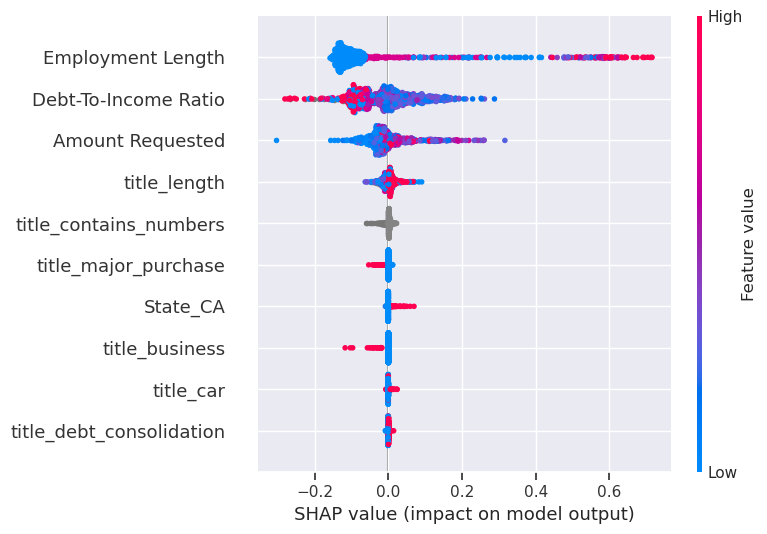

In [18]:
names = full_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).columns
explainer_tree = shap.TreeExplainer(
    full_pipeline["model"],
    data=full_pipeline["preprocess"]
    .transform((X_mini_val.sample(100, seed=1)))
    .to_numpy(),
    model_output="probability",
)

shap_values = explainer_tree.shap_values(
    full_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).to_numpy()
)

shap.summary_plot(
    shap_values,
    full_pipeline["preprocess"].transform(X_mini_val.sample(1000, seed=1)).to_numpy(),
    feature_names=names,
    max_display=10,
)

In [ ]:
imp=tr.PolarsNanImputer(fill_value=-1)


In [ ]:
from sklearn.tree import DecisionTreeClassifier

dtree=DecisionTreeClassifier()
full_pipeline_dtree= Pipeline(
    [
        ("preprocess", Pipeline([("imputer", imputer), ("encoder", encoder), ("null_imputer", imp)])),
        ("model", dtree),
    ]
)

In [ ]:
full_pipeline_dtree.fit(X_mini_train, y_mini_train)
preds_dtree = full_pipeline_dtree.predict(X_mini_val)
print(classification_report(y_mini_val, preds_dtree))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96     13866
           1       0.53      0.53      0.53      1134

    accuracy                           0.93     15000
   macro avg       0.75      0.75      0.75     15000
weighted avg       0.93      0.93      0.93     15000

